<a href="https://colab.research.google.com/github/nmonson1/othello_MI/blob/main/NBM_Othello_for_serimats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hi Neel!

This was a super fun project, thanks :) I didn't keep careful track of exactly how long I spent on it, but I bet it was more than 20 hours--to be fair, after ten hours I don't think I'd finished re-creating GPT-2 yet. If you only count from when I created this workbook, it could well be under 10 hours.

The vast majority of code in here is copy-pasted from you, and a bit from StefanHex's post "How-to Transformer Mechanistic Interpretability—in 50 lines of code or less!", but I've added a fair amount of comments. You should probably skip reading anything in a section labeled "Boring".

The "probing the cached games" section has almost no original code, but lots of comments on my thought process as I was reading your code/trying to understand the probe. Feel free to skip.

mistakes:
-overly conservative in error calculation (1/3 when actually assymetric between positive and negative
-added bias uniformly in subsets--should add single bias to all


Cells labeled #NN code are directly copied from Neel Nanda's workbook, and I don't necessarily know how they work (I haven't even read some lines in some of them)


# Boring background imports

In [ ]:
#NN code
# Janky code to do different setup when run in a Colab notebook vs VSCode
DEVELOPMENT_MODE = False
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
    %pip install transformer_lens==1.2.1
    %pip install git+https://github.com/neelnanda-io/neel-plotly

    # PySvelte is an unmaintained visualization library, use it as a backup if circuitsvis isn't working
    # # Install another version of node that makes PySvelte work way faster
    # !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
    # %pip install git+https://github.com/neelnanda-io/PySvelte.git
except:
    IN_COLAB = False
    print("Running as a Jupyter notebook - intended for development only!")
    from IPython import get_ipython

    ipython = get_ipython()
    # Code to automatically update the HookedTransformer code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")

Running as a Colab notebook
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.5/80.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 67.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.5/237.5 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.5 MB/s 

In [ ]:
#NN code
# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio
if IN_COLAB or not DEVELOPMENT_MODE:
    pio.renderers.default = "colab"
else:
    pio.renderers.default = "notebook_connected"
print(f"Using renderer: {pio.renderers.default}")

Using renderer: colab


In [ ]:
#NN code
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.auto as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

In [ ]:
#NN Code
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

In [ ]:
#NN code
torch.set_grad_enabled(False)

In [ ]:
#NN code
from neel_plotly import line, scatter, imshow, histogram

# Boring model+sample training loading

In [ ]:
#NN code
import transformer_lens.utils as utils
cfg = HookedTransformerConfig(
    n_layers = 8,
    d_model = 512,
    d_head = 64,
    n_heads = 8,
    d_mlp = 2048,
    d_vocab = 61,
    n_ctx = 59,
    act_fn="gelu",
    normalization_type="LNPre"
)
model = HookedTransformer(cfg)

In [ ]:
#NN code
sd = utils.download_file_from_hf("NeelNanda/Othello-GPT-Transformer-Lens", "synthetic_model.pth")
# champion_ship_sd = utils.download_file_from_hf("NeelNanda/Othello-GPT-Transformer-Lens", "championship_model.pth")
model.load_state_dict(sd)

<All keys matched successfully>

In [ ]:
#NN code
if IN_COLAB:
    !git clone https://github.com/likenneth/othello_world
    OTHELLO_ROOT = Path("/content/othello_world/")
    import sys
    sys.path.append(str(OTHELLO_ROOT/"mechanistic_interpretability"))
    from mech_interp_othello_utils import plot_single_board, to_string, to_int, int_to_label, string_to_label, OthelloBoardState
else:
    OTHELLO_ROOT = Path("/workspace/othello_world/")
    from tl_othello_utils import plot_single_board, to_string, to_int, int_to_label, string_to_label, OthelloBoardState

Cloning into 'othello_world'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 70 (delta 15), reused 10 (delta 10), pack-reused 43
Unpacking objects: 100% (70/70), 10.01 MiB | 7.38 MiB/s, done.


In [ ]:
#NN code
board_seqs_int = torch.tensor(np.load(OTHELLO_ROOT/"board_seqs_int_small.npy"), dtype=torch.long)
board_seqs_string = torch.tensor(np.load(OTHELLO_ROOT/"board_seqs_string_small.npy"), dtype=torch.long)

num_games, length_of_game = board_seqs_int.shape
print("Number of games:", num_games,)
print("Length of game:", length_of_game)

Number of games: 100000
Length of game: 60


In [ ]:
#NN code
stoi_indices = [
    0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
]
alpha = "ABCDEFGH"


def to_board_label(i):
    return f"{alpha[i//8]}{i%8}"


board_labels = list(map(to_board_label, stoi_indices))

In [ ]:
#SCRATCH
#grab game 55, look at first 40 moves
moves_int = board_seqs_int[55, :40]

#apply model to it. Should recieve logits which represent scores of various squares being legal for a 41st move.
logits = model(moves_int)
print("logits:", logits.shape)
logit_vec = logits[0, -1]
#[0,-1] because batch size 1 (0) and looking at possibilities for next move after final of 40 (-1)
#now, convert scores to probabilities
log_probs = logit_vec.log_softmax(-1)

# Remove passing (almost never legal move)
log_probs = log_probs[1:]
assert len(log_probs)==60 #so far so good?

temp_board_state = torch.zeros(64, device=logit_vec.device)
# Set all cells to -15 by default, for a very negative log prob - this means the middle cells don't show up as mattering
temp_board_state -= 15.
temp_board_state[stoi_indices] = log_probs

def plot_square_as_board(state, diverging_scale=True, **kwargs):
    """Takes a square input (8 by 8) and plot it as a board. Can do a stack of boards via facet_col=0"""
    if diverging_scale:
        imshow(state, y=[i for i in alpha], x=[str(i) for i in range(8)], color_continuous_scale="RdBu", color_continuous_midpoint=0., aspect="equal", **kwargs)
    else:
        imshow(state, y=[i for i in alpha], x=[str(i) for i in range(8)], color_continuous_scale="Blues", color_continuous_midpoint=None, aspect="equal", **kwargs)
plot_square_as_board(temp_board_state.reshape(8, 8), zmax=0, diverging_scale=True, title="Example Log Probs")

logits: torch.Size([1, 40, 61])


In [ ]:
#Did we find the right moves? We did!
plot_single_board(int_to_label(moves_int))

#equivalently
board = OthelloBoardState()
board.update(to_string(moves_int))
plot_square_as_board(board.state, title="Example Board State (+1 is Black, -1 is White)")

#or as a list
print("Valid moves:", string_to_label(board.get_valid_moves()))

Valid moves: ['A3', 'A4', 'B4', 'B5', 'B6', 'B7', 'C0', 'F0', 'G5', 'H0', 'H1', 'H2', 'H3', 'H4', 'H5', 'H6']


In [ ]:
#grab a tractable list of games, one-hot encode them
num_games = 50
focus_games_int = board_seqs_int[1000:1000+num_games]
focus_games_string = board_seqs_string[1000:1000+num_games]

def one_hot(list_of_ints, num_classes=64):
    out = torch.zeros((num_classes,), dtype=torch.float32)
    out[list_of_ints] = 1.
    return out
#for each game, at each timestep, at each board position, what is the state?
focus_states = np.zeros((num_games, 60, 8, 8), dtype=np.float32)
#for each game, at each timestep, which moves are valid?
focus_valid_moves = torch.zeros((num_games, 60, 64), dtype=torch.float32)
for i in (range(num_games)):
    board = OthelloBoardState()
    for j in range(60):
        board.umpire(focus_games_string[i, j].item())
        focus_states[i, j] = board.state
        focus_valid_moves[i, j] = one_hot(board.get_valid_moves())
print("focus states:", focus_states.shape)
print("focus_valid_moves", focus_valid_moves.shape)
model.cfg.use_attn_result = True
focus_logits, focus_cache = model.run_with_cache(focus_games_int[:, :-1])

focus states: (50, 60, 8, 8)
focus_valid_moves torch.Size([50, 60, 64])


# Probing the cached games

In [ ]:
#we load the probe
full_linear_probe = torch.load(OTHELLO_ROOT/"main_linear_probe.pth", map_location=torch.device('cpu'))
print(full_linear_probe.shape)
#the shape is 3, model_dimension, rows, columns, 3
#The first 3 is the mode of the probe. 0->black to play (odd moves). 1-> white to play (even moves). 2->all moves
#the final 3 is 0->empty, 1->white, 2->black
#IF I understand this correctly (BIG IF), I should think of this as a family of 3 functions
#    (the black probe, the white probe, and one that doesn't work)
#each function takes in the residual stream (model_dim) and spits out an 8x8 grid with associated scores, via dot-product
#To the extent this works, it shows the board state is encoded linearly in the residual stream
#Q: what layer(s) was this trained on??
#It isn't a priori obvious to me that the model will encode the board in the same dimensions of the residual stream at every layer

torch.Size([3, 512, 8, 8, 3])


In [ ]:
#print(full_linear_probe[0,:,0,0,0]) Yep, that looks like a list of numbers.
print(torch.std_mean(full_linear_probe[0,:,0,0,0]))
#apparently its a list of numbers with std .32 and mean -.0045. That looks close to 0 mean, which I think is unsuprising?

(tensor(0.3191, grad_fn=<StdMeanBackward0>), tensor(-0.0045, grad_fn=<StdMeanBackward0>))


In [ ]:
#We go ahead and convert this to a single function, by averaging the two functions that work, and thinking of the new final spot
#     as 0 -> blank, 1 -> (color just played), 2 -> (color to be played) (I may have those last 2 backwards)
rows = 8
cols = 8
options = 3
black_to_play_index = 0
white_to_play_index = 1
blank_index = 0
their_index = 1
my_index = 2
linear_probe = torch.zeros(cfg.d_model, rows, cols, options)
linear_probe[..., blank_index] = 0.5 * (full_linear_probe[black_to_play_index, ..., 0] + full_linear_probe[white_to_play_index, ..., 0])
linear_probe[..., their_index] = 0.5 * (full_linear_probe[black_to_play_index, ..., 1] + full_linear_probe[white_to_play_index, ..., 2])
linear_probe[..., my_index] = 0.5 * (full_linear_probe[black_to_play_index, ..., 2] + full_linear_probe[white_to_play_index, ..., 1])
def get_probe_outputs(layer, game_index, move, **kwargs):
    residual_stream = focus_cache["resid_post", layer][game_index, move]
    #print("residual_stream", residual_stream.shape)
    probe_out = einops.einsum(residual_stream, linear_probe, "d_model, d_model row col options -> row col options")
    return probe_out.softmax(dim=-1)
    #
def contrast_probe_outputs(layer, game_index, move, **kwargs):
    probabilities = get_probe_outputs(layer, game_index, move, **kwargs)
    plot_square_as_board(probabilities, facet_col=2, facet_labels=["P(Empty)", "P(Their's)", "P(Mine)"], height=400, width=600, **kwargs)
    plot_single_board(int_to_label(focus_games_int[game_index, :move+1]))

In [ ]:
# Now we look at a move from a game from our focus set.
layer = 6
game_index = 3
move = 10 #after move 0, 5 stones on the board
contrast_probe_outputs(layer, game_index, move)
#it looks like we understand it (at layer 6, anyway)

In [ ]:
layer = 6
game_index = 1
move = 10
for i in range(8):
    layer = i
    probabilities = get_probe_outputs(layer, game_index, move)
    plot_square_as_board(probabilities, facet_col=2, facet_labels=["P(Empty)", "P(Their's)", "P(Mine)"], height=400, width=600)
#It looks like we develop an understanding of the board which is terrible after layer 0 and still bad after layers 1,2,3.
#     After 4,5,6, things look great. Then, right before we make outputs (after layer 7), we're no longer just trying to represent the board, so the probe goes crazy.

In [ ]:
#linear_probe = d_model x rows x cols x [blank, just_played, to_play]
sq_linear_probe=torch.square(linear_probe)
magnitudes = torch.sqrt(einops.reduce(sq_linear_probe, "d_model r c o -> r c o", "sum"))
norm_linear_probe = linear_probe/magnitudes
#print(magnitudes[:, :, 1])
#It seems reasonable to hope that, for any given cell, (blank) and (just_played) will be related (and thus have non-zero dot product)
#and similarly with (blank) and (to_play)
blank_dot_last = torch.round(10*einsum("d r c, d r c -> r c", norm_linear_probe[:,:,:,0], norm_linear_probe[:,:,:,1]))
blank_dot_next = torch.round(10*einsum("d r c, d r c -> r c", norm_linear_probe[:,:,:,0], norm_linear_probe[:,:,:,2]))
#print(blank_dot_last, blank_dot_next)
#yep, looks like significant negative correlation for most cells. The exceptions are the central 4 cells, which makes sense--they're never blank!
#The sum of the two non-blanks should be the opposite direction of the blank
notblank = einops.reduce(linear_probe[:,:,:,1:], "d r c o -> d r c", "sum")
notblank_mag = torch.sqrt(einops.reduce(torch.square(notblank), "d_model r c -> r c", "sum"))
norm_notblank = notblank/notblank_mag
blank_dot_sum_notblank = torch.round(10*einsum("d r c, d r c -> r c", norm_linear_probe[:,:,:,0], norm_notblank))
#print(blank_dot_sum_notblank)
#yep, we are getting lots of -9 and -10, which means almost exactly opposite direction. again, the 4 central cells are excepted.
#This gives some evidence of Neel Nanda's claim that
#   "blank - (mine + their's)/2 [gives] a 'is this cell empty or not' direction"
#I'm not sure why this should give something better than just the "blank" direction though?

torch.Size([192])


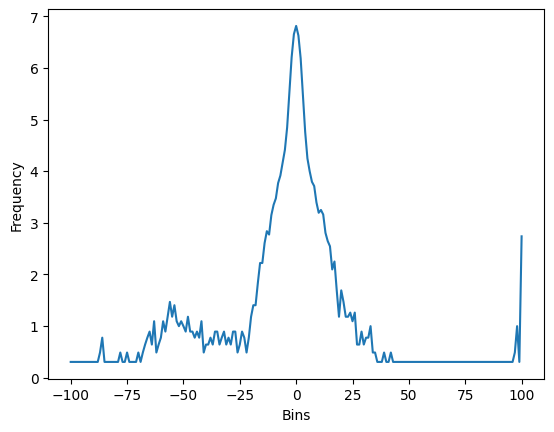

In [ ]:
#We can also check the entire probe for correlations
import matplotlib.pyplot as plt
linear_probe.shape
reshaped_probe = einops.rearrange(linear_probe, "model_dim r c m ->model_dim (r c m) ")
reshaped_probe.shape
norms = torch.linalg.vector_norm(reshaped_probe, dim=0)
print(norms.shape)
all_dots = einsum("r c1, r c2 -> c1 c2", reshaped_probe, reshaped_probe)
normed_dots = all_dots/einsum("() c1, () c2 -> c1 c2", norms, norms)

hist = torch.histc(100*normed_dots, bins = 201, min = -100, max = 100)
x = range(-100, 101)
#plt.plot(x[:], hist)
plt.plot(x[:], torch.log(10+hist)-2)
plt.xlabel('Bins')
plt.ylabel('Frequency')
plt.show()

#It looks like most vectors in the probe are close to uncorrelated, which makes sense. Many more have some negative correlation
#   (a given cells blankness, last_played_color, and next_played_color should all have negative correlation). There's a spike at
#   full correlation, which is each vector being correlated with itself. The smaller spike right next to that might be interesting, though!

# How does the model compute blank-ness of a given cell?

In [ ]:
#We will want both activations and weights of the model. Let's make sure we understand how to get those.

#for key, value in focus_cache.items():
#    print(key, value.shape)
print(focus_cache)
for i in model.named_parameters():
    if ".0." in i[0] or "blocks" not in i[0]:
        print(i[0], i[1].shape)
#It looks like the parameters don't show any learned weights for the LayerNorms?
#so focus_cache is a dictionary with the below objects. Let's make sure we understand some of the relationships
#The positional embeddings shouldn't depend on which game we look at
a = torch.equal(focus_cache["hook_pos_embed"][4,:,:], focus_cache["hook_pos_embed"][27,:,:])
#the initial inputs should be the sums of the embeddings
b = torch.equal(focus_cache["hook_embed"]+focus_cache["hook_pos_embed"], focus_cache["blocks.0.hook_resid_pre"])
print(a,b) #True, true. Very true.

ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.attn.hook_result', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.attn.hook_result', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.ho

In [ ]:
#lets consider cell (6,6), also known as cell 50 (of 0-59) or 51 (of 1-60)
#we grab the linear probe that tests its blankness
is_66_blank_probe = linear_probe[:,6,6,0]
torch.histogram(10*is_66_blank_probe, bins = 20)
#most of the values cluster around 0, suggesting something sparse-ish. Good!

torch.return_types.histogram(
hist=tensor([ 1.,  4.,  2.,  5.,  4., 17., 21., 33., 55., 76., 76., 61., 57., 43.,
        34., 16.,  4.,  2.,  0.,  1.], grad_fn=<NotImplemented>),
bin_edges=tensor([-14.4601, -13.0813, -11.7024, -10.3236,  -8.9448,  -7.5659,  -6.1871,
         -4.8083,  -3.4294,  -2.0506,  -0.6718,   0.7071,   2.0859,   3.4647,
          4.8436,   6.2224,   7.6012,   8.9801,  10.3589,  11.7377,  13.1166],
       grad_fn=<NotImplemented>))

In [ ]:
#The question "is this cell occupied" sure seems like it should correlate with the embedding and unembedding
#We'll use 51 for the cell identifier because we haven't removed the "pass" move.
embed_66 = model.embed.W_E[51,:]
unembed_66 = model.unembed.W_U[:,51]
is_66_blank_probe = linear_probe[:,6,6,0]
#print(unembed_66.shape, is_66_blank_probe.shape)
a = torch.nn.functional.cosine_similarity(embed_66, is_66_blank_probe, dim = 0)
b = torch.nn.functional.cosine_similarity(unembed_66, is_66_blank_probe, dim = 0)
#c = torch.nn.functional.cosine_similarity(unembed_66, embed_66, dim = 0) This was a pretty small number--not sure what that means.
print(a,b)

#.43 suggests a somewhat similar direction, but a long way from parallel. How does that compare with the other squares?
for i in range(45, 55):
    unembed_vec = model.unembed.W_U[:,i]
    print(i, torch.nn.functional.cosine_similarity(unembed_vec, is_66_blank_probe, dim = 0))
#clearly, MUCH more closely related! good, it would be weird otherwise

for i in range(45, 55):
    embed_vec = model.embed.W_E[i,:]
    print(i, torch.nn.functional.cosine_similarity(embed_vec, is_66_blank_probe, dim = 0))
#The embed vector looks a little less extreme, but still clearly more correlated than the surroundings.
#The signs are opposite, which is to be expected. When we embed the move, that suggests not-blank. When we play the move, that suggests blank.


tensor(-0.1736, grad_fn=<SumBackward1>) tensor(0.4314, grad_fn=<SumBackward1>)
45 tensor(-0.0059, grad_fn=<SumBackward1>)
46 tensor(-0.0101, grad_fn=<SumBackward1>)
47 tensor(0.0023, grad_fn=<SumBackward1>)
48 tensor(0.0022, grad_fn=<SumBackward1>)
49 tensor(0.0207, grad_fn=<SumBackward1>)
50 tensor(0.0256, grad_fn=<SumBackward1>)
51 tensor(0.4314, grad_fn=<SumBackward1>)
52 tensor(-0.0447, grad_fn=<SumBackward1>)
53 tensor(-0.0164, grad_fn=<SumBackward1>)
54 tensor(-0.0060, grad_fn=<SumBackward1>)
45 tensor(0.0523, grad_fn=<SumBackward1>)
46 tensor(0.0455, grad_fn=<SumBackward1>)
47 tensor(0.0265, grad_fn=<SumBackward1>)
48 tensor(0.0352, grad_fn=<SumBackward1>)
49 tensor(0.0166, grad_fn=<SumBackward1>)
50 tensor(-0.0570, grad_fn=<SumBackward1>)
51 tensor(-0.1736, grad_fn=<SumBackward1>)
52 tensor(0.0224, grad_fn=<SumBackward1>)
53 tensor(-0.0123, grad_fn=<SumBackward1>)
54 tensor(0.0354, grad_fn=<SumBackward1>)


In [ ]:
#lets look severely out of distribution.
all_51s = torch.diag(51*torch.ones(58, dtype = torch.long),diagonal = -1)
print(all_51s)
mono_logits, mono_cache = model.run_with_cache(all_51s)

tensor([[ 0,  0,  0,  ...,  0,  0,  0],
        [51,  0,  0,  ...,  0,  0,  0],
        [ 0, 51,  0,  ...,  0,  0,  0],
        ...,
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ..., 51,  0,  0],
        [ 0,  0,  0,  ...,  0, 51,  0]])


In [ ]:
gamecheck = 0
logit_vec = mono_logits[gamecheck, gamecheck,:]
#now, convert scores to probabilities
log_probs = logit_vec.log_softmax(-1)

# Remove passing (almost never legal move)
log_probs = log_probs[1:]
assert len(log_probs)==60 #so far so good?

temp_board_state = torch.zeros(64, device=logit_vec.device)
# Set all cells to -15 by default, for a very negative log prob - this means the middle cells don't show up as mattering
temp_board_state -= 15.
temp_board_state[stoi_indices] = log_probs

plot_square_as_board(temp_board_state.reshape(8, 8), zmax=0, diverging_scale=False, title="Example Log Probs")

#It seems like this doesn't work at all. I was imagining "passing" as neutral, but I think the model believes (correctly!)
#      that passing indicates a severely restricted boardstate, so most moves are probably illegal.
#It generally seems to not have anything special about cell 51 = (6,6) = g6, unless im grossly wrong about something.


In [ ]:
#Lets try again, this time with an opening that gets to the sqaure quickly.
short_logits, short_cache = model.run_with_cache(torch.tensor([41,42,43,51]))
logit_vec = short_logits[0, 3 ,:]
#now, convert scores to probabilities
log_probs = logit_vec.log_softmax(-1)

# Remove passing (almost never legal move)
log_probs = log_probs[1:]
assert len(log_probs)==60 #so far so good?

temp_board_state = torch.zeros(64, device=logit_vec.device)
# Set all cells to -15 by default, for a very negative log prob - this means the middle cells don't show up as mattering
temp_board_state -= 15.
temp_board_state[stoi_indices] = log_probs

plot_square_as_board(temp_board_state.reshape(8, 8), zmax=0, diverging_scale=False, title="Example Log Probs")
#okay, so between index 2 and 3, the model correctly changes from (6,6) being playable to being occupied.

In [ ]:
"""ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out', 'blocks.1.hook_resid_post', 'blocks.2.hook_resid_pre', 'blocks.2.ln1.hook_scale', 'blocks.2.ln1.hook_normalized', 'blocks.2.attn.hook_q', 'blocks.2.attn.hook_k', 'blocks.2.attn.hook_v', 'blocks.2.attn.hook_attn_scores', 'blocks.2.attn.hook_pattern', 'blocks.2.attn.hook_z', 'blocks.2.hook_attn_out', 'blocks.2.hook_resid_mid', 'blocks.2.ln2.hook_scale', 'blocks.2.ln2.hook_normalized', 'blocks.2.mlp.hook_pre', 'blocks.2.mlp.hook_post', 'blocks.2.hook_mlp_out', 'blocks.2.hook_resid_post', 'blocks.3.hook_resid_pre', 'blocks.3.ln1.hook_scale', 'blocks.3.ln1.hook_normalized', 'blocks.3.attn.hook_q', 'blocks.3.attn.hook_k', 'blocks.3.attn.hook_v', 'blocks.3.attn.hook_attn_scores', 'blocks.3.attn.hook_pattern', 'blocks.3.attn.hook_z', 'blocks.3.hook_attn_out', 'blocks.3.hook_resid_mid', 'blocks.3.ln2.hook_scale', 'blocks.3.ln2.hook_normalized', 'blocks.3.mlp.hook_pre', 'blocks.3.mlp.hook_post', 'blocks.3.hook_mlp_out', 'blocks.3.hook_resid_post', 'blocks.4.hook_resid_pre', 'blocks.4.ln1.hook_scale', 'blocks.4.ln1.hook_normalized', 'blocks.4.attn.hook_q', 'blocks.4.attn.hook_k', 'blocks.4.attn.hook_v', 'blocks.4.attn.hook_attn_scores', 'blocks.4.attn.hook_pattern', 'blocks.4.attn.hook_z', 'blocks.4.hook_attn_out', 'blocks.4.hook_resid_mid', 'blocks.4.ln2.hook_scale', 'blocks.4.ln2.hook_normalized', 'blocks.4.mlp.hook_pre', 'blocks.4.mlp.hook_post', 'blocks.4.hook_mlp_out', 'blocks.4.hook_resid_post', 'blocks.5.hook_resid_pre', 'blocks.5.ln1.hook_scale', 'blocks.5.ln1.hook_normalized', 'blocks.5.attn.hook_q', 'blocks.5.attn.hook_k', 'blocks.5.attn.hook_v', 'blocks.5.attn.hook_attn_scores', 'blocks.5.attn.hook_pattern', 'blocks.5.attn.hook_z', 'blocks.5.hook_attn_out', 'blocks.5.hook_resid_mid', 'blocks.5.ln2.hook_scale', 'blocks.5.ln2.hook_normalized', 'blocks.5.mlp.hook_pre', 'blocks.5.mlp.hook_post', 'blocks.5.hook_mlp_out', 'blocks.5.hook_resid_post', 'blocks.6.hook_resid_pre', 'blocks.6.ln1.hook_scale', 'blocks.6.ln1.hook_normalized', 'blocks.6.attn.hook_q', 'blocks.6.attn.hook_k', 'blocks.6.attn.hook_v', 'blocks.6.attn.hook_attn_scores', 'blocks.6.attn.hook_pattern', 'blocks.6.attn.hook_z', 'blocks.6.hook_attn_out', 'blocks.6.hook_resid_mid', 'blocks.6.ln2.hook_scale', 'blocks.6.ln2.hook_normalized', 'blocks.6.mlp.hook_pre', 'blocks.6.mlp.hook_post', 'blocks.6.hook_mlp_out', 'blocks.6.hook_resid_post', 'blocks.7.hook_resid_pre', 'blocks.7.ln1.hook_scale', 'blocks.7.ln1.hook_normalized', 'blocks.7.attn.hook_q', 'blocks.7.attn.hook_k', 'blocks.7.attn.hook_v', 'blocks.7.attn.hook_attn_scores', 'blocks.7.attn.hook_pattern', 'blocks.7.attn.hook_z', 'blocks.7.hook_attn_out', 'blocks.7.hook_resid_mid', 'blocks.7.ln2.hook_scale', 'blocks.7.ln2.hook_normalized', 'blocks.7.mlp.hook_pre', 'blocks.7.mlp.hook_post', 'blocks.7.hook_mlp_out', 'blocks.7.hook_resid_post', 'ln_final.hook_scale', 'ln_final.hook_normalized']
embed.W_E torch.Size([61, 512])
pos_embed.W_pos torch.Size([59, 512])
blocks.0.attn.W_Q torch.Size([8, 512, 64])
blocks.0.attn.W_K torch.Size([8, 512, 64])
blocks.0.attn.W_V torch.Size([8, 512, 64])
blocks.0.attn.W_O torch.Size([8, 64, 512])
blocks.0.attn.b_Q torch.Size([8, 64])
blocks.0.attn.b_K torch.Size([8, 64])
blocks.0.attn.b_V torch.Size([8, 64])
blocks.0.attn.b_O torch.Size([512])
blocks.0.mlp.W_in torch.Size([512, 2048])
blocks.0.mlp.b_in torch.Size([2048])
blocks.0.mlp.W_out torch.Size([2048, 512])
blocks.0.mlp.b_out torch.Size([512])
unembed.W_U torch.Size([512, 61])
unembed.b_U torch.Size([61])"""
# Obvious thing to try: see what happens to the embed vector for token 51.
embedded_token = model.embed.W_E[51, :]
#we would normally add a positional embedding vector to it. Does this interact?
#for i in range(59):
#    pos_embed_vec = model.pos_embed.W_pos[i,:]
#    print(i,torch.round(100*torch.nn.functional.cosine_similarity(pos_embed_vec, embedded_token, dim = 0)))
#it looks like the cosine similarity is under .1 for all possible positions, so we aren't interacting much. Good!

#I'd hope that the answer to "Given that 6,6 was just played, how much attention should we pay to the xth move of the game?"
#   would be pretty low. On the other hand, the question "If a head is looking for when 6,6 was played, it was here!" should be high.
#   Thus, I anticipate W_Q being small for all 8 heads, and W_K being high for at least one head.
Q_weights = model.blocks[0].attn.W_Q
Q_vecs = einsum("heads d_model h_dim, d_model -> heads h_dim", Q_weights, embedded_token)
print("Q norms: ",torch.linalg.vector_norm(Q_vecs+model.blocks[0].attn.b_Q, dim=1))

K_weights = model.blocks[0].attn.W_K
K_vecs = einsum("heads d_model h_dim, d_model -> heads h_dim", K_weights, embedded_token)
print("K norms: ",torch.linalg.vector_norm(K_vecs+model.blocks[0].attn.b_K, dim=1))

V_weights = model.blocks[0].attn.W_V
V_vecs = einsum("heads d_model h_dim, d_model -> heads h_dim", V_weights, embedded_token)
print("V norms: ",torch.linalg.vector_norm(V_vecs+model.blocks[0].attn.b_V, dim=1))

#Well, I was very wrong.

Q norms:  tensor([1.9552, 3.1259, 3.8038, 2.8002, 3.9612, 4.1889, 2.7038, 3.3021],
       grad_fn=<LinalgVectorNormBackward0>)
K norms:  tensor([3.7769, 1.2165, 3.6754, 3.6053, 1.0492, 0.9768, 2.6344, 2.2578],
       grad_fn=<LinalgVectorNormBackward0>)
V norms:  tensor([0.6905, 1.1243, 0.6386, 0.7951, 1.1136, 1.0767, 0.8428, 0.7547],
       grad_fn=<LinalgVectorNormBackward0>)


In [ ]:
model.cfg.use_attn_result = True
short_logits, short_cache = model.run_with_cache(torch.tensor([[41,42,43,49],[41,42,43,51]]))
is_66_blank_probe = linear_probe[:,6,6,0]
is_64_blank_probe = linear_probe[:,6,4,0]
#for key, value in short_cache.items():
#    print(key, value.shape)
for i in range(8):
    actives = short_cache["blocks."+str(i)+".hook_resid_pre"]
    print(actives.shape)
    active_no_66 = actives[0,3,:]
    active_yes_66 = actives[1,3,:]
    diff = active_yes_66 - active_no_66
    cos_sim = torch.round(100*torch.nn.functional.cosine_similarity(active_no_66, active_yes_66, dim = 0))
    print("after layer ", i, "cos similarity of ", cos_sim)
    print("diff of ", torch.norm(diff), " with dot ", torch.dot(is_66_blank_probe, diff))


torch.Size([2, 4, 512])
after layer  0 cos similarity of  tensor(52.)
diff of  tensor(4.1729)  with dot  tensor(-5.0460, grad_fn=<DotBackward0>)
torch.Size([2, 4, 512])
after layer  1 cos similarity of  tensor(55.)
diff of  tensor(7.6725)  with dot  tensor(-15.7606, grad_fn=<DotBackward0>)
torch.Size([2, 4, 512])
after layer  2 cos similarity of  tensor(68.)
diff of  tensor(9.0547)  with dot  tensor(-16.2463, grad_fn=<DotBackward0>)
torch.Size([2, 4, 512])
after layer  3 cos similarity of  tensor(76.)
diff of  tensor(9.6563)  with dot  tensor(-19.0321, grad_fn=<DotBackward0>)
torch.Size([2, 4, 512])
after layer  4 cos similarity of  tensor(80.)
diff of  tensor(10.4740)  with dot  tensor(-24.0198, grad_fn=<DotBackward0>)
torch.Size([2, 4, 512])
after layer  5 cos similarity of  tensor(82.)
diff of  tensor(12.0212)  with dot  tensor(-28.3955, grad_fn=<DotBackward0>)
torch.Size([2, 4, 512])
after layer  6 cos similarity of  tensor(77.)
diff of  tensor(16.6284)  with dot  tensor(-29.3592, 

In [ ]:
#is_66_blank_probe = linear_probe[:,6,6,0]
#is_64_blank_probe = linear_probe[:,6,4,0]
actives = short_cache["blocks.6.hook_resid_pre"]
probed_boardstates = einsum("d r c o, b m d -> b m r c o", linear_probe, actives)
probed_boardstates = probed_boardstates[:,3,:,:,:]
probabilities = probed_boardstates[0].softmax(dim=-1)
plot_square_as_board(probabilities, facet_col=2, facet_labels=["P(Empty)", "P(Their's)", "P(Mine)"], height=400, width=600)

In [ ]:
actives = short_cache["blocks.0.hook_resid_pre"]
probed_boardstates = einsum("d r c o, b m d -> b m r c o", linear_probe, actives)
probed_boardstates = probed_boardstates[:,3,:,:,:]
probabilities = probed_boardstates[0].softmax(dim=-1)
plot_square_as_board(probabilities, facet_col=2, facet_labels=["P(Empty)", "P(Their's)", "P(Mine)"], height=400, width=600)
probabilities = probed_boardstates[1].softmax(dim=-1)
plot_square_as_board(probabilities, facet_col=2, facet_labels=["P(Empty)", "P(Their's)", "P(Mine)"], height=400, width=600)
#After just the first layer (blocks.0 to blocks.1), the model has gone from "go home, model, you're drunk" to basically correct about what is blank
#Lets see if we can find exactly where that happens


In [ ]:
block_list = ['blocks.0.hook_resid_pre',
'blocks.0.attn.hook_q',
'blocks.0.attn.hook_k',
'blocks.0.attn.hook_v',
'blocks.0.attn.hook_attn_scores',
'blocks.0.attn.hook_pattern',
'blocks.0.attn.hook_z',
'blocks.0.hook_attn_out',
'blocks.0.hook_resid_mid',
'blocks.0.ln2.hook_scale',
'blocks.0.ln2.hook_normalized',
'blocks.0.mlp.hook_pre',
'blocks.0.mlp.hook_post',
'blocks.0.hook_mlp_out',
'blocks.0.hook_resid_post']
for block in block_list:
    print(short_cache[block][1].shape)

torch.Size([4, 512])
torch.Size([4, 8, 64])
torch.Size([4, 8, 64])
torch.Size([4, 8, 64])
torch.Size([8, 4, 4])
torch.Size([8, 4, 4])
torch.Size([4, 8, 64])
torch.Size([4, 512])
torch.Size([4, 512])
torch.Size([4, 1])
torch.Size([4, 512])
torch.Size([4, 2048])
torch.Size([4, 2048])
torch.Size([4, 512])
torch.Size([4, 512])


In [ ]:
actives = short_cache["blocks.0.hook_resid_mid"]
probed_boardstates = einsum("d r c o, b m d -> b m r c o", linear_probe, actives)
probed_boardstates = probed_boardstates[:,3,:,:,:]
probabilities = probed_boardstates[0].softmax(dim=-1)
plot_square_as_board(probabilities, facet_col=2, facet_labels=["P(Empty)", "P(Their's)", "P(Mine)"], height=400, width=600)
probabilities = probed_boardstates[1].softmax(dim=-1)
plot_square_as_board(probabilities, facet_col=2, facet_labels=["P(Empty)", "P(Their's)", "P(Mine)"], height=400, width=600)
#okay, so it looks like the model has a pretty good idea of whether 64 or 66 has been played after *only the first attention layer*--no MLP needed!
#  (Although in the case that 64 is played, it seems very uncertain about 65??)

In [ ]:
#What are the heads paying attention to?
short_cache["blocks.0.attn.hook_pattern"].shape
#for i in range(2):
#    for j in range(8):
#        print(torch.round(10*short_cache["blocks.0.attn.hook_pattern"][i,j,3]))
#The patterns looks similar between the 2 games. Heads 4 and 5 seem most focused on the current move--maybe they  are responsible for recording blankness?
probe_for_blanks = linear_probe[:,:,:,:] #recall [model_dim, r, c, options]
head_outs = short_cache["blocks.0.attn.hook_result"][:, 3, 4:6, :] #[game_id, move#, head_id, model_dim]

probed_outs = einsum("model_dim r c o, game_id head model_dim -> game_id head r c o", probe_for_blanks, head_outs)
probabilities = probed_outs[1,1].softmax(dim=-1)
plot_square_as_board(probabilities, facet_col=2, facet_labels=["P(Empty)", "P(Their's)", "P(Mine)"], height=400, width=600)
#Head 4 seems not super-helpful, but head 5 seems promising.

In [ ]:
#This was very ad-hoc and small sample-sized. My background is pure math, not stat, but even I'm uncomfortable
#    drawing conclusions from sample size 2. Let's do something more systematic
print("focus states:", focus_states.shape) #[game_id, move#, r, c]
#print("focus_valid_moves", focus_valid_moves.shape) #[game_id, move#, cell#]
#print("focus logits:", focus_logits.shape) #[game_id, move#, pass_or_cellid]
#print("focus cache:", len(focus_cache))
#focus_cache["blocks.0.hook_resid_mid"].shape #[game_id, move#, model_dim]
#linear_probe.shape #[model_dim, r, c, o]
#Based on previous work above, we conjecture:
#CONJECTURE 1
#   the model knows the non-blankness of the most-recently played cell after the first (0th) attention layer,
#   and know it in a way extractable by the linear probe. Testing that:

probed_after_attn0 = einsum("game_id move model_dim, model_dim r c o -> game_id move r c o", focus_cache["blocks.0.hook_resid_mid"], linear_probe)
game_id = 42
move_num = 37
probabilities = probed_after_attn0[game_id,move_num].softmax(dim=-1)
plot_square_as_board(probabilities, facet_col=2, facet_labels=["P(Empty)", "P(Their's)", "P(Mine)"], height=400, width=600)
plot_single_board(int_to_label(focus_games_int[game_id, :move_num+1]))
blank_truth = 1-torch.abs(torch.tensor(focus_states[:,:-1]))
errors = torch.abs(blank_truth-(probed_after_attn0.softmax(dim=-1)[...,0]))
rounded_errors = torch.nn.functional.threshold(errors, .33, 0)
square_errors = einops.reduce(rounded_errors,"game move r c-> r c", "sum")
square_errors_mag = einops.reduce(rounded_errors,"game move r c-> r c", "mean")
count_errors = torch.count_nonzero(rounded_errors, dim = [0,1])

focus states: (50, 60, 8, 8)


In [ ]:
#plot_square_as_board(square_errors, height=400, width=600)
print(count_errors.shape)
plot_square_as_board(count_errors/(50*59), height=400, width=600, zmax = 1, zmin = -1)

#It looks like the total accuracy is pretty high, except for the corners. Conjecture 1' confirmed!!
#CONJECTURE 1': the model knows, not just non-blankness of most recently played cell
#but also the blankness-status of almost every cell.
#We still haven't actually confirmed conjecture 1, but it should be easy at this point

torch.Size([8, 8])


In [ ]:
print(focus_games_int.shape)
print(errors.shape)

torch.Size([50, 60])
torch.Size([50, 59, 8, 8])


In [ ]:
current_move_errors = torch.zeros_like(errors)
def move_int_to_boardpos(i):

    x=stoi_indices[i-1] #we aren't passing
    return x//8, x%8
for x in range(50):
    for y in range(59):
        movea, moveb = move_int_to_boardpos(focus_games_int[x,y])
        current_move_errors[x,y,movea, moveb]+=1
current_move_errors = current_move_errors*rounded_errors
current_move_errors = current_move_errors[:, :, :,:]
count_current_errors = torch.count_nonzero(current_move_errors, dim = [0,1])

In [ ]:
#current_move_error_rate = einops.reduce(current_move_errors, "a b r c-> r c", "sum")
plot_square_as_board(count_current_errors, height=400, width=600, zmax = 50)
#We've confirmed conjecture 1...except for cell F4??

In [ ]:
imshow(current_move_errors[:,:,5,4])
focus_games_int[torch.argwhere(current_move_errors[:,0,5,4]>.2),0]
#focus_games_int[(current_move_)]
#It looks like our probe is not successful at extracting the non-blankness of F4 from our model when F4 is the first cell played.
#This could be because the model is storing the information for F4 elsewhere at this point, or the model will use a different head
#   or an MLP layer to tell


tensor([[41],
        [41],
        [41],
        [41],
        [41],
        [41],
        [41],
        [41],
        [41],
        [41],
        [41],
        [41],
        [41],
        [41]])

In [ ]:
#CONJECTURE 2: We can identify which attention head(s) the model does this with! Let's start by making sure we understand the tools
#probed_after_attn0 = einsum("game_id move model_dim, model_dim r c o -> game_id move r c o", focus_cache["blocks.0.hook_resid_mid"], linear_probe)
print(focus_cache["blocks.0.hook_resid_mid"].shape)
print(focus_cache["blocks.0.attn.hook_result"].shape) #[batch, position, head, d_embed]
print(focus_cache["blocks.0.hook_resid_pre"].shape)
attn_sum = einops.reduce(focus_cache["blocks.0.attn.hook_result"], "a b c d -> a b d", "sum")
diff = focus_cache["blocks.0.hook_resid_mid"] - attn_sum
print(torch.equal(diff, focus_cache["blocks.0.hook_resid_pre"])) #False. Uh-oh
#print(torch.isclose(diff, focus_cache["blocks.0.hook_resid_pre"])) #Also false. Uh-oh.

N=100
#plt.plot(focus_cache["blocks.0.hook_resid_pre"][0,0,:N])
#plt.plot(diff[0,0,:N])
#okay, they aren't literally "the same", but it looks like floating point errors and pytorch being too strict with isclose.
print(focus_cache['blocks.0.hook_attn_out'].shape)

#plt.plot((focus_cache["blocks.0.hook_resid_pre"][0,0,:N]-diff[0,0,:N]))
#plt.plot(attn_sum[0,0,:N] - focus_cache["blocks.0.hook_attn_out"][0,0,:N])

#yeah, because hook_result is not the real thing which gets used, it's slightly off from attn_out
#The errors seem to be too big to be floating point errors, actually, but too small to be anything serious.
#I am confused by this--is there a bug in TransfomerLens?
#(an unreasonable amount of time later...)
#Okay, I went into the transfomerLens source code, and I think I found the issue, which is obvious in retrospect:
# blocks.0.attn.b_O has been added when forming attn_out, but there is no principled way to decompose it amongst the 8 heads, so hook_result doesn't include it at all!
#confirming:
#plt.plot(model.blocks[0].attn.b_O.detach().numpy()[:N])
#plt.plot((focus_cache["blocks.0.hook_resid_pre"][0,0,:N]-diff[0,0,:N]))
#Yep, pretty clearly one is the negative of the other

biased_hooks = focus_cache["blocks.0.attn.hook_result"]+(model.blocks[0].attn.b_O/8)
biased_attn_sum = einops.reduce(biased_hooks, "a b c d -> a b d", "sum")
diff = focus_cache["blocks.0.hook_resid_mid"] - biased_attn_sum
print(torch.equal(diff, focus_cache["blocks.0.hook_resid_pre"]))
print(torch.isclose(diff, focus_cache["blocks.0.hook_resid_pre"]))
#Okay, so lets work with the biased_hooks

torch.Size([50, 59, 512])
torch.Size([50, 59, 8, 512])
torch.Size([50, 59, 512])
False
torch.Size([50, 59, 512])


In [ ]:
hypo_resid_mids = biased_hooks+einops.repeat(focus_cache["blocks.0.hook_resid_pre"], "game move model_dim ->game move heads model_dim", heads = 8)
heads_probed_after_attn0 = einsum("game_id move heads model_dim, model_dim r c o -> game_id move heads r c o", hypo_resid_mids, linear_probe)
blank_truth = 1-torch.abs(torch.tensor(focus_states[:,:-1]))
blank_truth_rep = einops.repeat(blank_truth,"game_id move r c ->game_id move heads r c", heads = 8)

errors = torch.abs(blank_truth_rep-(heads_probed_after_attn0.softmax(dim=-1)[...,0]))
rounded_errors = torch.nn.functional.threshold(errors, .33, 0)
square_errors = einops.reduce(rounded_errors,"game move heads r c-> heads r c", "sum")
square_errors_mag = einops.reduce(rounded_errors,"game move heads r c-> heads r c", "mean")
count_errors = torch.count_nonzero(rounded_errors, dim = [0,1])

In [ ]:
for i in range(8):
    plot_square_as_board(count_errors[i]/(50*59), height=400, width=600, zmax = 1, zmin = -1)
#well, this is a bit disconcerting. Visual inspection doesn't make it look like any head is more or less good at this overall.


In [ ]:
best_case_error_count = einops.reduce(count_errors, "heads r c->r c", "min")
plot_square_as_board(best_case_error_count/(50*59), height=400, width=600, zmax = 1, zmin = -1)
#Comparing this with the resid_mid error picture, It seems pretty clear that no cell has an individual head that write blankness into the residual stream--all the cells are composite.
#Can we at least find cell/head pairs where the head does NOT help?

In [ ]:
def subset_to_error_count(x):
    subset_of_biased_hooks = biased_hooks[:,:,x,:]
    subset_hypo_resid_mids = einops.reduce(subset_of_biased_hooks, "game_id move heads model_dim -> game_id move model_dim", "sum")+focus_cache["blocks.0.hook_resid_pre"]
    probed_resid_subset = einsum("game_id move model_dim, model_dim r c o -> game_id move r c o", subset_hypo_resid_mids, linear_probe)
    subset_errors = torch.abs(blank_truth-(probed_resid_subset.softmax(dim=-1)[...,0]))
    subset_rounded_errors = torch.nn.functional.threshold(subset_errors, .33, 0)
    subset_count_errors = torch.count_nonzero(subset_rounded_errors, dim = [0,1])
    return subset_count_errors
for i in range(8):
    diff = count_errors[i]-subset_to_error_count([i])
    plot_square_as_board(diff/(50*59), height=400, width=600, zmax = 1, zmin = -1)
#our function seems to work?

In [ ]:
all_subset_errors = torch.empty((256, 8,8))

for i in range(256):
    bin_string = bin(i)[2:]
    binstring = ("0"*(8-len(bin_string)))+bin_string
    subset = [7-j for j in range(8) if int(binstring[j])]
    board = subset_to_error_count(subset)
    all_subset_errors[i] = board

In [ ]:
torch.argmin(all_subset_errors, dim = 0)

tensor([[123, 127, 255, 255, 255, 255, 235, 251],
        [239, 255, 255, 255, 255, 251, 255, 127],
        [223, 255, 254, 254, 254, 255, 255, 255],
        [255, 255, 254, 162, 224, 190, 255, 255],
        [255, 255, 251, 225, 161, 251, 255, 255],
        [255, 255, 255, 254, 254, 255, 255, 255],
        [253, 255, 127, 255, 254, 255, 255, 255],
        [251, 255, 253, 255, 223, 255, 253, 255]])

In [ ]:
tiered_subsets = []
for i in range(9):
    subsets = set()
    tiered_subsets.append(subsets)
for i in range(256):
    bin_string = bin(i)[2:]
    binstring = ("0"*(8-len(bin_string)))+bin_string
    subset = [7-j for j in range(8) if int(binstring[j])]
    tiered_subsets[len(subset)].add(frozenset(subset))


In [ ]:
def set_to_num(x):
    val = 0
    for power in x:
        val+=2**power
    return int(val)

In [ ]:
paths = []

for i in range(8):
    li = []
    for j in range(8):
        lj = [ set()]
        for k in range(1,8):
            min = 10000
            best_head = 10
            for head in set([0,1,2,3,4,5,6,7])-lj[-1]:
                #print("checking ", head, " in ", set([0,1,2,3,4,5,6,7])-lj[-1])

                if all_subset_errors[set_to_num(set.union(lj[-1],set([head]))),i,j] < min:
                    #print("updating previous best", min, " to ", all_subset_errors[set_to_num(set.union(lj[-1],set([head]))),i,j], "as a result of ", i, j, k, head)
                    min = all_subset_errors[set_to_num(set.union(lj[-1],set([head]))),i,j]
                    best_head = head
            lj.append(set.union(lj[k-1],set([best_head])))

        li.append(lj)
    paths.append(li)


In [ ]:
all_subset_errors.shape

torch.Size([256, 8, 8])

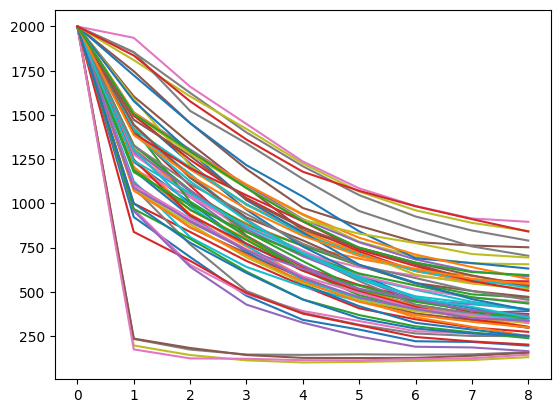

In [ ]:
all_cells = torch.empty((64, 8))
for i in range(64):
    errors = [2000]
    x,y = i//8, i%8
    for j in range(8):
        err = errors[-1]
        if set_to_num(paths[x][y][j])<256:
            err = all_subset_errors[set_to_num(paths[x][y][j])][x][y]
        errors.append(err)
        all_cells[i,j]=err
    plt.plot(errors)
plt.savefig("fountain", dpi = 100, bbox_inches = "tight")

In [ ]:
#print(torch.argmin(all_cells, dim = 0))
#print(all_cells[35], all_cells[27])
a,b = torch.sort(all_cells[:,0])
print(a, b)

tensor([ 175.,  197.,  234.,  236.,  839.,  923.,  957.,  968.,  969., 1000.,
        1000., 1072., 1081., 1088., 1089., 1089., 1102., 1112., 1125., 1177.,
        1186., 1189., 1192., 1207., 1235., 1241., 1246., 1248., 1277., 1286.,
        1300., 1305., 1310., 1327., 1327., 1329., 1387., 1394., 1396., 1403.,
        1404., 1419., 1424., 1425., 1443., 1445., 1473., 1496., 1505., 1505.,
        1506., 1508., 1514., 1515., 1578., 1592., 1605., 1724., 1747., 1810.,
        1836., 1854., 1855., 1936.]) tensor([36, 28, 27, 35, 43, 20, 44, 26, 52, 13, 60, 51, 38, 54, 25, 37, 46, 34,
        19, 42, 30, 32, 16, 21,  0, 59, 11, 33,  6,  4, 24, 29,  1,  2, 47, 12,
        61, 49, 53,  9,  3, 39, 22, 31, 17, 45, 55, 23,  8, 62, 10, 58, 14, 41,
        50, 18,  5, 40, 15, 48, 63,  7, 57, 56])


In [ ]:
bestheads = [0]*10
for i in range(8):
    for j in range(8):
        bestheads[(list(paths[i][j][1])[0])]+=1

In [ ]:
print(bestheads)


[13, 12, 5, 11, 11, 7, 1, 4, 0, 0]
